# Removing Glasses from an image through recursive PCA

### Objective/Overview:
By using PCA on a dataset of faces, you can use the principal components obtained by performing PCA to reconstruct any face from the dataset perfectly. However, if you were to take an image not from the dataset, the reconstruction will not be perfectly. For example, if you were to perform PCA on a dataset of people without glasses, and then attempt to reconstruct a face with glasses using the principal components of glasses dataset, the reconstructed face would have no glasses. However, this image would not quite accurately reflect the appearance of the person if they took off their glasses. As such, this project aims to reconstruct the face of a person with glasses to a relatively high degree using the principal components of a dataset trained on faces without glasses.

There are 2 methods we attempted below that aim to reconstruct the face of a person with glasses without their glasses
1. The first method, devised and performed by Yifei Du, aims to take the glasses off a person by performing PCA on both the glassless dataset and glasses dataset. Then, taking the input glass image and subtracting by the mean face of the glasses dataset. 
2. The second method, based off of the paper provided in the Reference section (paper by Jeong-Seon Park, You Hwa Oh, Sang Chul Ahn, and Seong-Whan Lee), aims to take the glasses off a person by recursively reconstructing the input image and replacing sections of the image with either the mean face or the previous iteration of the reconstructed face
###### (further details are listed in the Methods Section)
###### Reference: [Glasses Removal from Facial Image Using Recursive PCA Reconstruction](https://www.researchgate.net/publication/221597943_Glasses_Removal_from_Facial_Image_Using_Recursive_PCA_Reconstruction) 

## Setup Data

### Import Necessary Libraries

In [195]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

### Load Data
The dataset, known as the AT&T Database of Faces foud on Kaggle which is linked below, contains 40 folders (found under the images directory). Each folder contains 10 pictures of a different person, with each picture varying in lighting, facial expressions, and other qualities. Each picture is 112 x 92 pixels.

###### [AT&T Database of Faces](https://www.kaggle.com/datasets/kasikrit/att-database-of-faces)

In [196]:
# Load Imgaes Images as Dataset
def load_pgm_images(amount_of_people, amount_of_pics):
    images = []
    for person in range(1, amount_of_people+1):
        images.append([])
        for image_number in range(1, amount_of_pics+1):
            img = Image.open('images/s' + str(person) + '/' + str(image_number) + '.pgm')
            images[person-1].append(img)
    return np.array(images)
    
def display_pgm_images(images, person_numbers, pic_numbers):
    rows, cols = len(person_numbers), len(pic_numbers)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 8))

    row = 0
    for i in person_numbers:
        col = 0
        for j in pic_numbers:
            ax = axes[row, col]
            ax.imshow(images[i][j], cmap='gray')
            ax.axis('off')
            col += 1
        row += 1
            
    plt.tight_layout()
    plt.show()

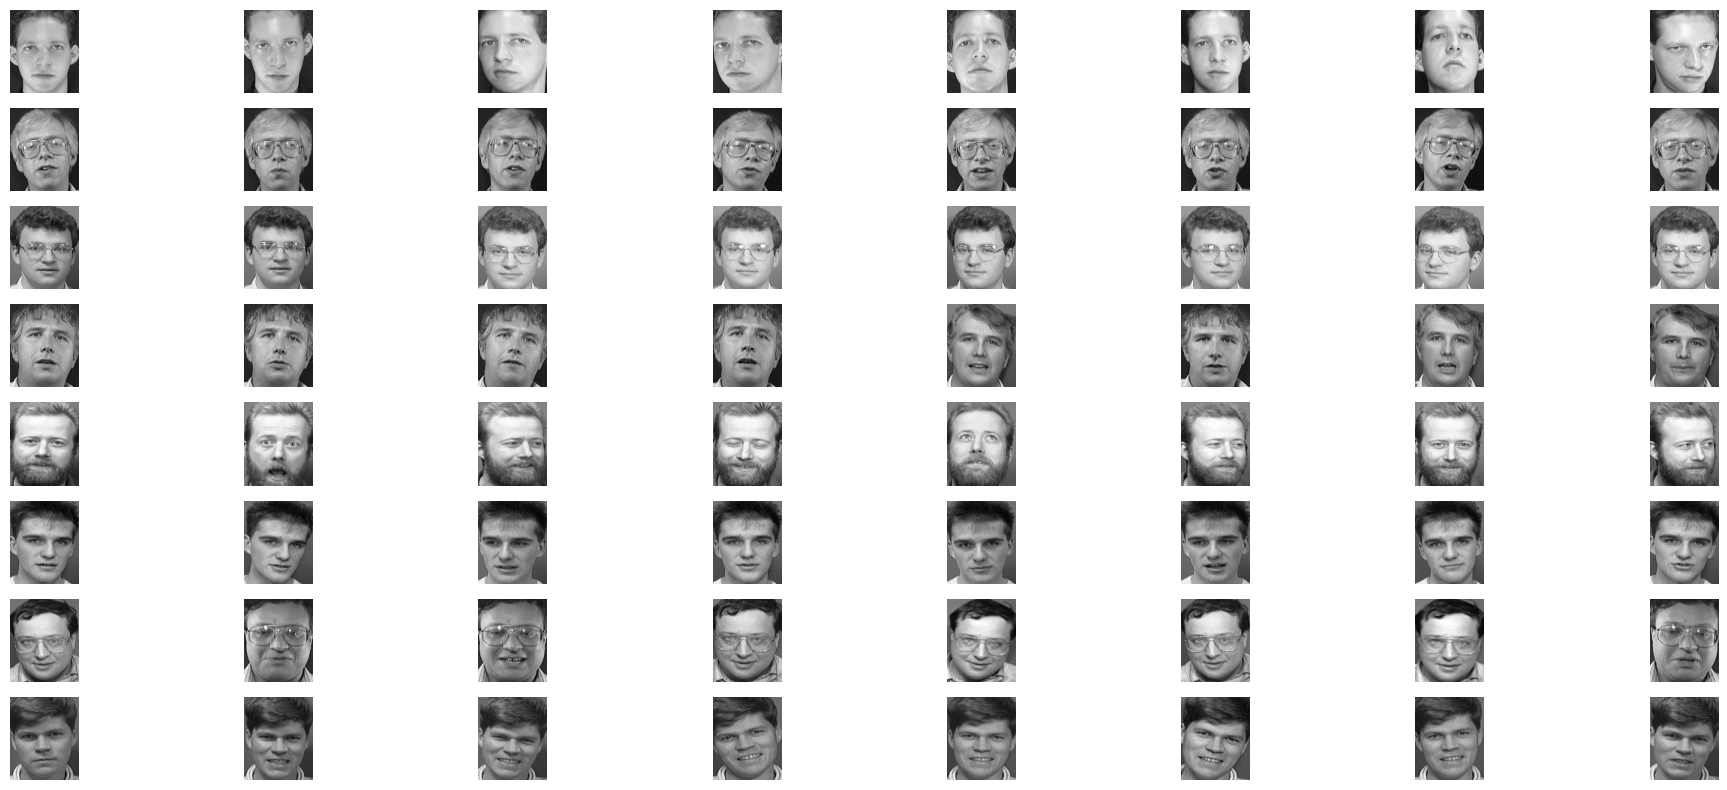

In [197]:
# Example of images from dataset
amount_of_people = 40
amount_of_pics = 10
person_numbers = [0, 1, 5, 14, 25, 29, 30, 32]
pic_numbers = [0, 2, 3, 5, 6, 7, 8, 9]
images = load_pgm_images(40, 10)
display_pgm_images(images, person_numbers, pic_numbers)

### Process Data
Currently, we have a 40 x 10 x 112 x 92 matrix as our dataset. We need to both find the glassless images and change the format of the matrix so that it is a 2D array instead of a 4D one. In addition to finding the glassless images, we have also chosen to only include the male images in our dataset as their are far more males than females from the AT&T dataset, and this would simplify the results of the project.

(10304, 72)


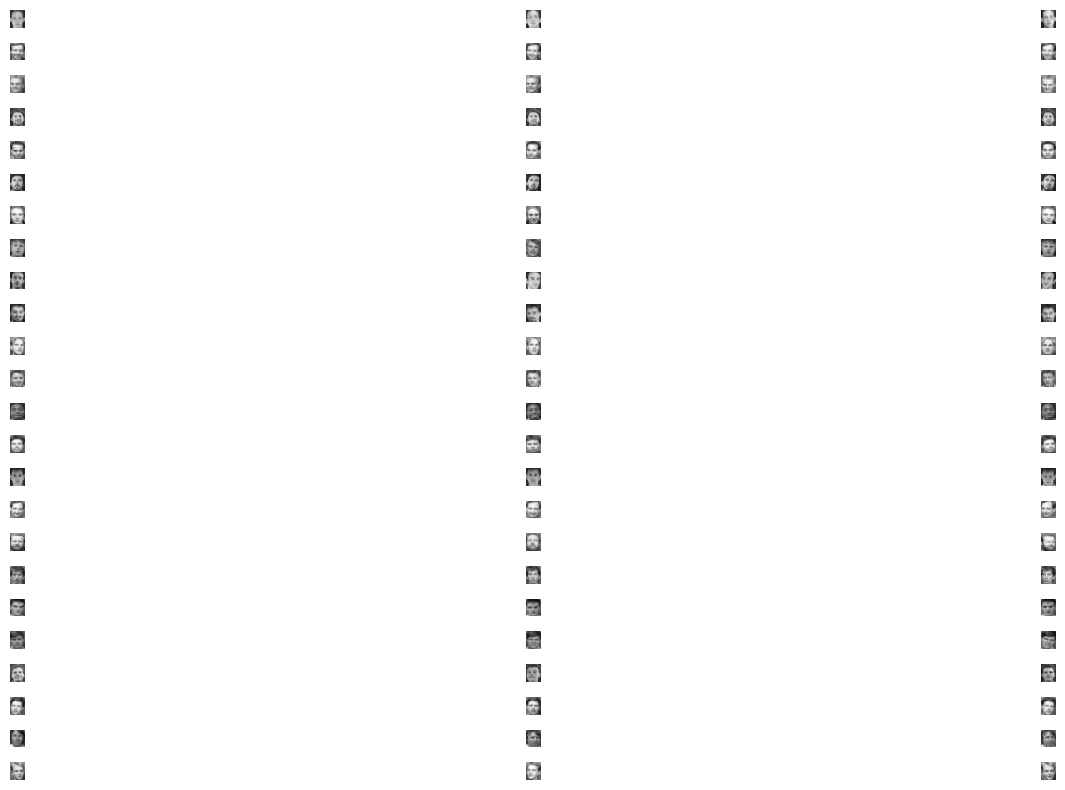

In [198]:
# Create Dataset of Male and Without Glasses
selected_people = [0, 2, 4, 6, 8, 10, 11, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 28, 29, 32, 35, 37, 38, 39]
male_no_glasses_imgs = np.array([images[i] for i in selected_people])
selected_imgs = [0, 6, 7]

# Create Dataset for male with no glasses to perform PCA with
num_people = len(selected_people)
num_pictures = len(selected_imgs)
num_pixels = 112 * 92
num_images = num_people * num_pictures
ds = np.zeros((num_people, num_pictures, num_pixels))

# Function flattens matrix to n x 1 column
def flatten_matrix(matrix):
    return matrix.reshape(1, -1)

# flatten pixels
for i in range(num_people):
    for j in range(num_pictures):
        ds[i][j] = flatten_matrix(male_no_glasses_imgs[i][j])

# Flatten pictures
ds = ds.reshape(num_people * num_pictures, num_pixels)
ds = ds.T
print(ds.shape)
# Normalize columns

# Display selected pictures
display_pgm_images(images, selected_people, selected_imgs)

## Perform PCA on Glassless Dataset

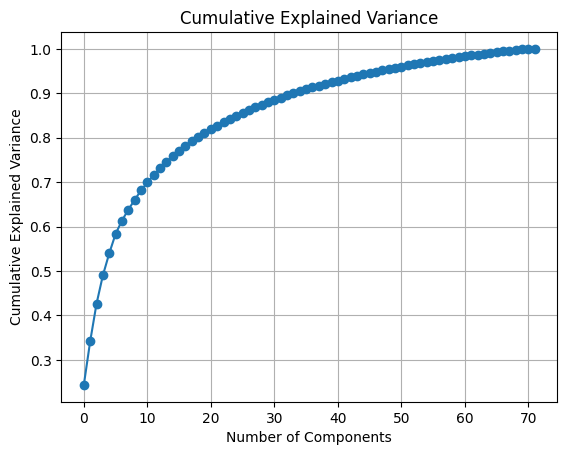

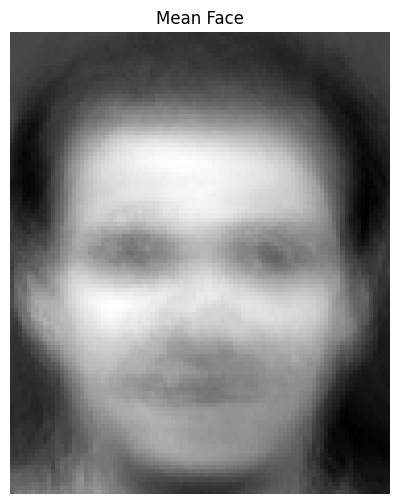

In [199]:
mean_face = np.mean(ds, axis=1, keepdims=True)
Z = ds - mean_face
pca = PCA()
principal_components = pca.fit_transform(Z.T)
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

reconstructed_ds = pca.inverse_transform(principal_components)

def visualize_faces(original, reconstructed, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[:, i].reshape((112, 92)), cmap='gray')
        plt.axis('off')
        plt.title('Original')

        plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].reshape((112, 92)), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(mean_face.reshape((112, 92)), cmap='gray')
plt.title('Mean Face')
plt.axis('off')
plt.show()

#print("Principal Components Shape:", principal_components.shape)
#print("Explained Variance Ratio:", explained_variance_ratio)
#print("Cumulative Explained Variance:", cumulative_variance)

### Reconstruct with Foruth of Principal Components

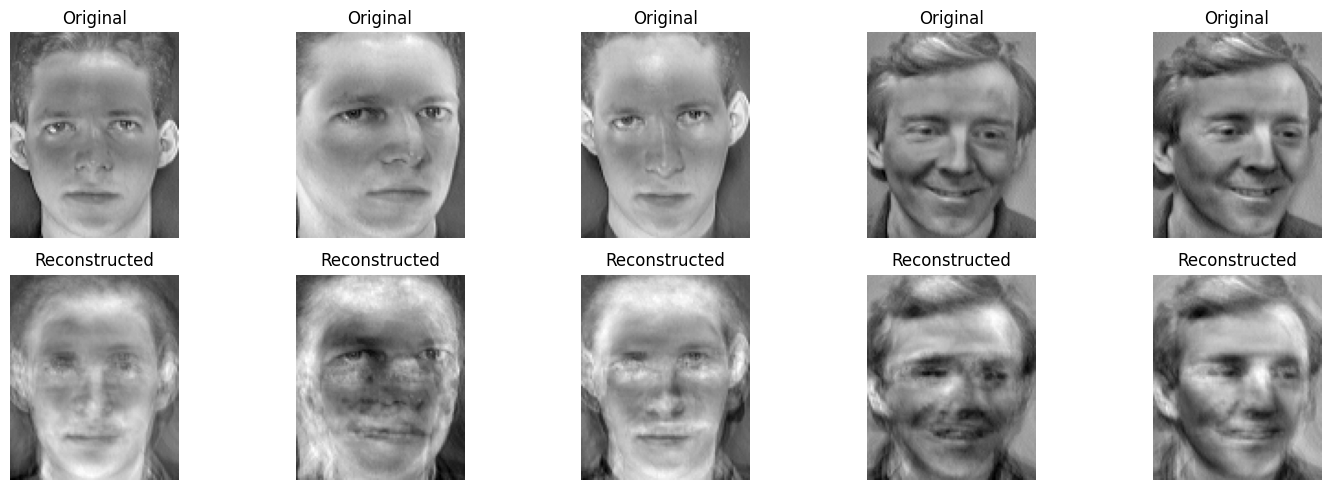

In [200]:
pca = PCA(n_components=int(num_images/4))
principal_components = pca.fit_transform(Z.T)
reconstructed_ds = pca.inverse_transform(principal_components)
visualize_faces(Z, reconstructed_ds, n=5)

### Reconstruct with Half of Principal Components

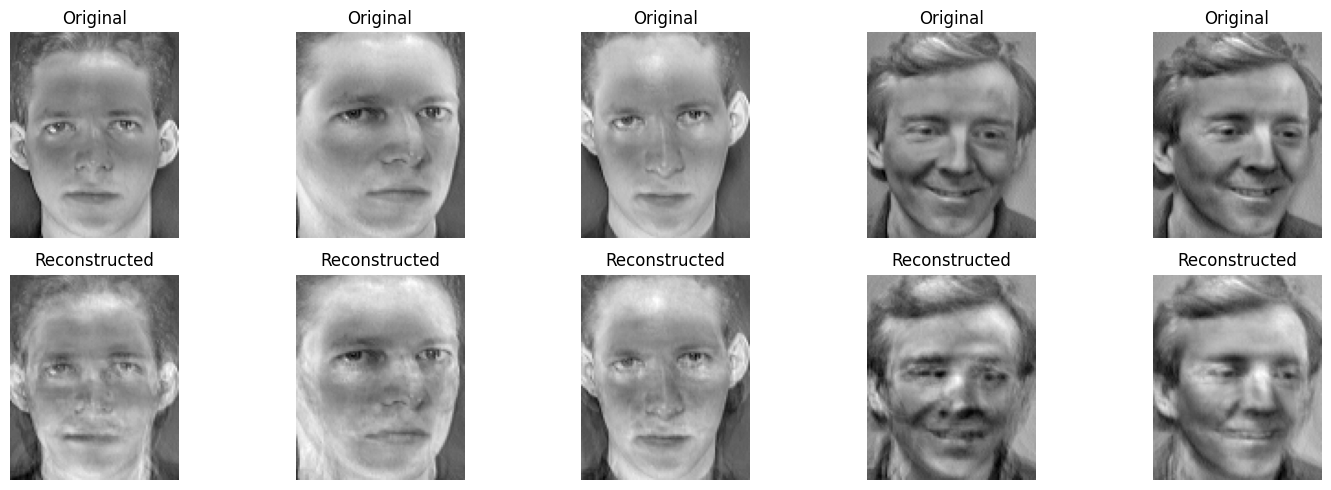

In [201]:
pca = PCA(n_components=int(num_images/2))
principal_components = pca.fit_transform(Z.T)
reconstructed_ds = pca.inverse_transform(principal_components)
visualize_faces(Z, reconstructed_ds, n=5)

### Reconstruct with All Principal Components

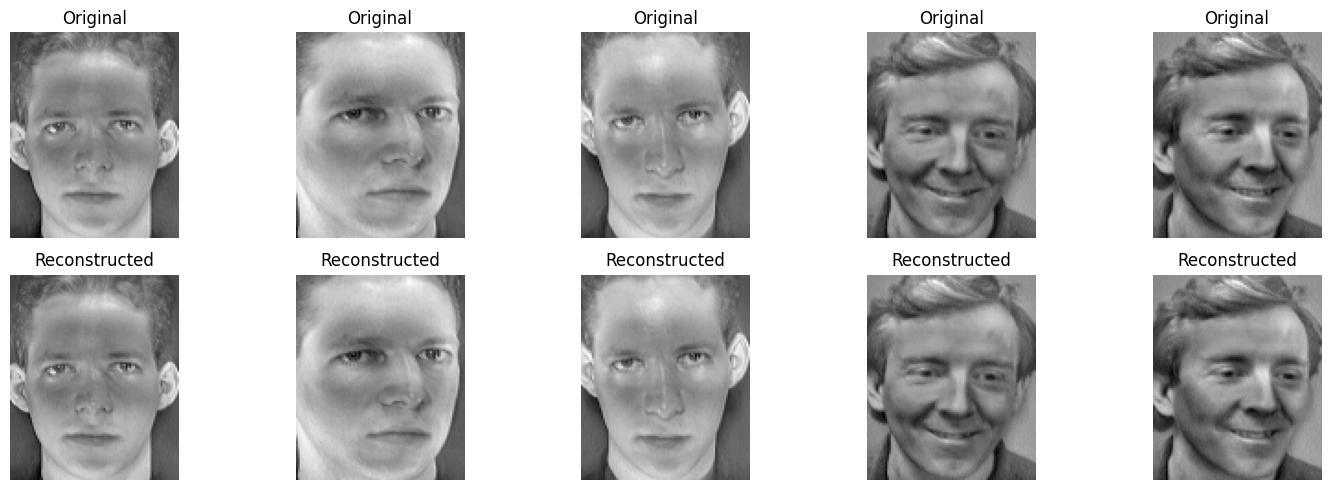

In [202]:
pca = PCA()
principal_components = pca.fit_transform(Z.T)
reconstructed_ds = pca.inverse_transform(principal_components)
visualize_faces(Z, reconstructed_ds, n=5)

## Perform PCA on Glass Dataset

(10304, 1)

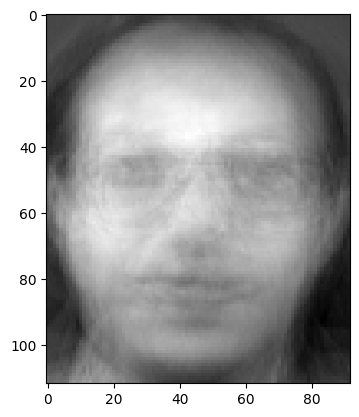

In [203]:
def viewcolumn(columnvector):
    # viewcolumn(columnvector);
    # VIEWCOLUMN Displays a 60 x 60 grayscale image stored in a column vector.
    # Tim Marks 2002
    plt.imshow(columnvector.reshape([112, 92], order='C'), cmap=plt.get_cmap('gray'))

# Create Dataset of Male and With Glasses
all_faces = set(range(40))
selected_people = [0, 2, 4, 6, 8, 10, 11, 14, 15, 17, 20, 21, 22, 23, 24, 25, 28, 29, 32, 35, 37, 38, 39]

selected_people2 = list(all_faces - set(selected_people))
male_yes_glasses_imgs = np.array([images[i] for i in selected_people2])

# Create Dataset for male with glasses to perform PCA with
num_people2 = len(selected_people2)
num_pictures = len(selected_imgs)
num_pixels = 112 * 92
ds_2 = np.zeros((num_people2, num_pictures, num_pixels))

# flatten pixels
for i in range(num_people2):
    for j in range(num_pictures):
        ds_2[i][j] = flatten_matrix(male_yes_glasses_imgs[i][j])

# Flatten pictures
ds_2 = ds_2.reshape(num_people2 * num_pictures, num_pixels)
ds_2 = ds_2.T

# compute the mean face of people without glasses
meanface_with_glasses = np.mean(ds_2, axis = 1)
meanface_with_glasses = meanface_with_glasses[:, np.newaxis]

viewcolumn(meanface_with_glasses)
meanface_with_glasses.shape

## Method 1: Subtracting Glass Dataset Mean Face from Input Glass Face
1. Find the mean face of the glasses dataset
2. Subtract the mean face of the glasses dataset from the input image


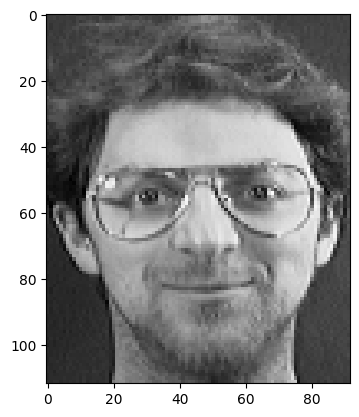

In [218]:
def eigsort(V, eigvals):
    # [Vsort,Dsort] = eigsort(V, eigvals)
    #
    # Sorts a matrix eigenvectors and a array of eigenvalues in order 
    # of eigenvalue size, largest eigenvalue first and smallest eigenvalue
    # last.
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort

def normc(Mat):
    # normc(M) normalizes the columns of M to a length of 1.
    return normalize(Mat, norm='l2', axis=0)

# Subtract the mean(with glasses) from the data of people with glasses
A = ds_2 - meanface_with_glasses

eigvals, V_old = np.linalg.eig(A.T.dot(A))
V, D = eigsort(V_old, eigvals)

U = A.dot(V)
U = normc(U)

face2_with_glasss = images[6][3]
c = U.T.dot(face2_with_glasss.reshape(112*92, 1) - meanface_with_glasses)
Zhat = U.dot(c) + mean_face
viewcolumn(face2_with_glasss)

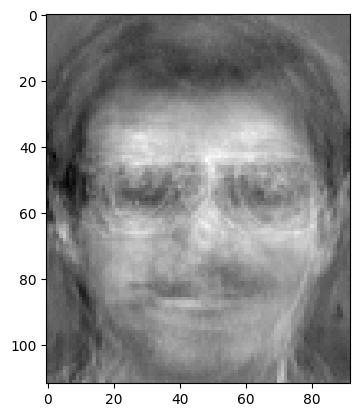

In [205]:
viewcolumn(Zhat)

## Method 2: Recursive PCA (Removing image with glasses using PCA on a glassless dataset)
1. Compute the principal components of the glassless dataset with PCA
2. 1st iteration of Recursive PCA
    * Take the input image (glass image) and reconstruct the face with PCA. This will create a glassless image with the areas around the eyes being poorly reconstructed
    * Create the difference image by finding the difference between the input image and the reconstructed image.
    * The difference image will have areas of low difference (areas where the image was reconstructed) and areas of high difference (areas where the image was reconstructed poorly). Find the mean of the lower difference values. This will be the threshold.
    * Replace the coordinates of the input image with the coordinates of the mean face where the pixel values of the difference image is higher than the threshold. This will be the 1st compensated image
3. Subsequent iterstions of Recurisve PCA.
    * Construct the new reconstructed image using the previous iteration's compensated image.
    * Find the difference image between the new reconstructed image and the original input image
    * Find the threshold the same way as it was found in the first iteration
    * Replace the coordiantes of the original input image with the coordinates of the reconstructed image where the pixel values of the difference image is higher than the threshold. This will be the new compensated image
4. Stopping Condition
    * If the Euclidean distance between the the current iteration's difference image and the previous iteration's difference is below some specified constant, then stop the Recursive PCA

In [222]:
# Recursive PCA

# Reconstruct Image with all principal components
def Reconstruct_Image(input_image, mean_face):
    input_centered = input_image.T - mean_face
    input_projected = pca.transform(input_centered)
    input_reconstructed = pca.inverse_transform(input_projected)
    input_reconstructed += mean_face
    return input_reconstructed.T

# Replace input image with high difference with replacing_image 
def Compensate_Image(input_image, replacing_image, difference_image, lower_threshold):
    compensated_image = np.zeros((input_image.shape[0], input_image.shape[1]))
    for i in range(difference_image.shape[0]):
        for j in range(difference_image.shape[1]):
            if (difference_image[i][j] >= lower_threshold):
                compensated_image[i][j] = replacing_image[i][j]
            else:
                compensated_image[i][j] = glass_image.reshape(112, 92)[i][j]
    return compensated_image.reshape(112*92, 1)

# Iteratively apply PCA to input_image to remove glasses
def Recursive_PCA(input_image, difference_stopping_condition):
    mean_face = np.mean(ds, axis=1)
    Z = np.zeros((ds.shape[0], ds.shape[1]))
    for i in range(Z.T.shape[0]):
        Z.T[i] = ds.T[i] - mean_face

    pca = PCA()
    pca.fit(Z.T)
    compensated_images = []

    # First iteration
    reconstructed_image = Reconstruct_Image(input_image, mean_face) # Reconstruct input_image
    difference_image = np.abs(input_image.reshape(112 * 92, 1) - reconstructed_image)
    threshold = Find_Thresholds(difference_image.T) # Obtain lower and higher thresholds from difference image
    compensated_image = Compensate_Image(input_image.reshape(112, 92), mean_face.reshape(112, 92), difference_image.reshape(112, 92), threshold)
    compensated_images.append(compensated_image.reshape(112, 92))
    
    # Subsequent Iterations
    difference = np.abs(compensated_image - input_image)
    while (np.linalg.norm(difference) > difference_stopping_condition):
        difference_image_prev = difference_image
        reconstructed_image = Reconstruct_Image(compensated_image, mean_face)
        difference_image = np.abs(input_image.reshape(112 * 92, 1) - reconstructed_image)
        threshold = Find_Thresholds(difference_image.T)
        compensated_image = Compensate_Image(input_image.reshape(112, 92), reconstructed_image.reshape(112, 92), difference_image.reshape(112, 92), threshold)
        compensated_images.append(compensated_image.reshape(112, 92))
        difference = np.abs(difference_image_prev - difference_image)

    return compensated_images

# Calculate Lower and Higher Thresholds
def Find_Thresholds(difference_image):
    difference_vals = difference_image[0][0:]
    difference_vals_sorted = sorted(difference_vals)
    max_difference_index1 = 0
    max_difference = 0

    for i in range(len(difference_vals)-1):
        difference = abs(difference_vals[i] - difference_vals[i+1])
        if (max(difference, max_difference) == difference):
            max_difference_index1 = i

    lower_difference = np.array(difference_vals_sorted[0:max_difference_index1+1])
    threshold = np.mean(lower_difference)
    return threshold

glass_image = images[6][3]
glass_image = glass_image.reshape(112 * 92, 1)
compensated_images = Recursive_PCA(glass_image, 1e-10)
print("Number of Iterations =", len(compensated_images))

Number of Iterations = 149


## Results
Below shows the input image, and the compensated image at various iterations of Recursive PCA

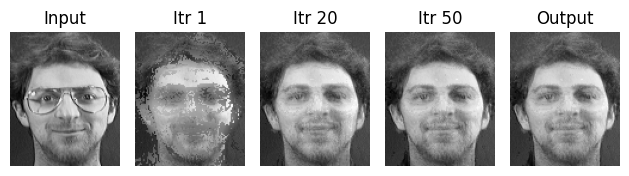

In [223]:
plt.subplot(1, 5, 1)
plt.imshow(glass_image.reshape(112, 92), cmap='gray')
plt.title("Input")
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(compensated_images[0], cmap='gray')
plt.title("Itr 1")
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(compensated_images[19], cmap='gray')
plt.title("Itr 20")
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(compensated_images[49], cmap='gray')
plt.title("Itr 50")
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(compensated_images[-1], cmap='gray')
plt.title("Output")
plt.axis('off')

plt.tight_layout()
plt.show()

Below shows the input image, the reconstructed image of the input image, and the output of Recurisve PCA (last iteration)

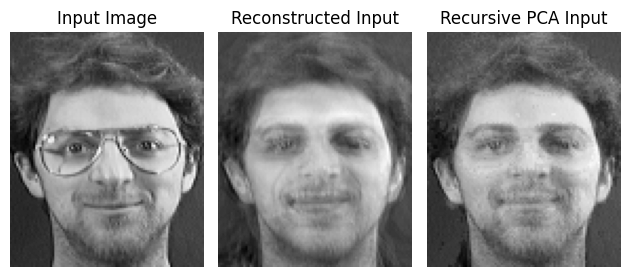

In [225]:
# Reconstructing Glass image regularly with all Principal Components

mean_face = np.mean(ds, axis=1)
Z = np.zeros((ds.shape[0], ds.shape[1]))
for i in range(Z.T.shape[0]):
    Z.T[i] = ds.T[i] - mean_face

pca = PCA()
pca.fit(Z.T)
input_centered = glass_image.T - mean_face
input_projected = pca.transform(input_centered)
input_reconstructed = pca.inverse_transform(input_projected)
input_reconstructed += mean_face


plt.subplot(1, 3, 1)
plt.imshow(glass_image.reshape(112, 92), cmap='gray')
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(input_reconstructed.T.reshape(112, 92), cmap='gray')
plt.title("Reconstructed Input")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(compensated_images[-1], cmap='gray')
plt.title("Recursive PCA Input")
plt.axis('off')

plt.tight_layout()
plt.show()